<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/Copy_of_Testing_multi_task_ANN_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trying to implement a multi task

In [1]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
!pip install pysptools

#this is the swarm optimization package
!pip install --upgrade pyswarm

#spotpy
!pip install spotpy

#bayesian optimization packages
!pip install bayesian-optimization

     |████████████████████████████████| 153kB 4.7MB/s 
     |████████████████████████████████| 8.1MB 5.1MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-cp36-none-any.whl size=8133747 sha256=d56765b156d45c1caa38bd0a02f80a2cae5132773b7936f7a620e6491f08cc05
  Stored in directory: /root/.cache/pip/wheels/bf/60/be/a6719d91bfa59135201feb034c7069e4146aa576fc0dc9e624
Successfully built pysptools
  Created wheel for pyswarm: filename=pyswarm-0.6-cp36-none-any.whl size=4479 sha256=5e63b36d3edcb9e701327b1afd236a17af23c8801061e05e34e11e7a81fb9c5f
  Stored in directory: /root/.cache/pip/wheels/37/c5/f6/b33b9ac00040cb95c1f00af982a4197334a672d6de43f4699f
Successfully built pyswarm
     |████████████████████████████████| 6.2MB 4.4MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=3e7e3ffdbf10caede038666e5db809560e7c912d5f8ce452f9a8ddfa7d45404c
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f2

In [0]:
#importing packages

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
def custom_prosail(cab,cw,cm,lai):
  import prosail
  #default parameters
  n= 1.
  car=10.
  cbrown=0.01
  typelidf=1 #this is the default option
  lidfa = -1 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot= 0.01 #hotspot parameters - got this from R package https://www.rdocumentation.org/packages/hsdar/versions/0.4.1/topics/PROSAIL
  #sun and viewing angle
  tts=30. #observation and solar position parameters
  tto=10. 
  psi=0.
  #for now i put them by hand but they should be an input of a custom function
  #tts=sol_zen #solar zenith angle
  #tto=inc_zen #sensor zenith angle
  #psi=raa
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,
                                 hspot,
                                 tts,tto,psi,
                                 typelidf, lidfb,
                                 prospect_version="D",
                                 factor='SDR', 
                                 rsoil=.1, psoil=.5)
  return(rho_out)

#test call:
custom_prosail(40,.005,.005,2)

array([0.02147451, 0.02147321, 0.02147204, ..., 0.02853143, 0.02829189,
       0.02836254])

In [0]:
def Prosail2S2(path2csv,spectra_input):
  #importing pandas
  import pandas as pd
  import numpy
  import numpy as np
  #upload a S2_Response.csv from https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses

  s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec

  s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
  spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
  rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
  w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

  output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

  return output[1:] #removes the first value because it represents the wavelength column


#please LOAD THTE FILE NOW
filepath="/content/S2_Response.csv"
#filepath="/content/S2_Responses_S2B.csv"
filepath="/content/drive/My Drive/S2_Response.csv"

In [0]:
def Gen_spectra_data(traits):
  k = 1
  #pd_train_traits=traits
  #print(range(len(traits)))
  for i in range(len(traits)):
    #n_t = pd_train_traits["n"][i]
    cab_t = traits["cab"][i]
    #car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = traits["cw"][i]
    cm_t = traits["cm"][i]
    lai_t = traits["lai"][i]

    if k == 1:
      tr_rho_s = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_s = Prosail2S2(filepath,tr_rho_s)
      #plt.plot ( x, tr_rho_s, ':', label="Training prosail")
      #plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_t = Prosail2S2(filepath,tr_rho_t)
      tr_rho_s = np.vstack((tr_rho_s,tr_rho_t))
      #plt.plot ( x, tr_rho_t, ':')

    k = k+1


  rho_samples=tr_rho_s


  return rho_samples

In [0]:
#number of samples
train_n3000 = 10000

n_traits=4 #I will test on 4 varying traits: cab, car, cw,cm,lai

#generating a LHS hypercube (it uses a 0 to 1 interval that can be used as a multiplier against the different traits)
np.random.seed(0)
LHS_train3000 = lhsmdu.createRandomStandardUniformMatrix(n_traits,train_n3000 ) #the package has a more advanced method but it is too slow to process

#maxmins from here also: https://github.com/jgomezdans/prosail/issues/10

#max_n=1 #this value should go from 1 to 2, so i make it change from 0 to 1 here and then add 1 later
max_cab=90. #add 1
#max_car=44. #add 1
#max_cbrown= 9.99 #add 0.01
max_cw=0.0039 #0.008 #add 0.001 
max_cm=0.0039 #0.008 #0.001
max_lai = 6 #add 0.1


min_cab = 10.
min_cw = 0.002
min_cm = 0.002
min_lai = .5

In [0]:
#preparing function inputs


pd_traits3000 = pd.DataFrame.transpose(pd.DataFrame(LHS_train3000))
pd_traits3000.columns = ["cab","cw","cm","lai"]

pd_traits3000["cab"]=pd_traits3000["cab"]*max_cab+min_cab
pd_traits3000["cw"] =pd_traits3000["cw"] *max_cw +min_cw
pd_traits3000["cm"] =pd_traits3000["cm"] *max_cm +min_cm
pd_traits3000["lai"]=pd_traits3000["lai"]*max_lai+min_lai

np_spectra3000 = Gen_spectra_data(pd_traits3000)

In [13]:
print(pd_traits3000)

            cab        cw        cm       lai
0     59.393215  0.003614  0.003462  4.320172
1     74.367043  0.004456  0.003672  5.900273
2     64.248704  0.005036  0.004664  5.143716
3     59.039486  0.005321  0.004344  1.273192
4     48.128932  0.005184  0.002275  0.899944
...         ...       ...       ...       ...
2995  94.751836  0.002407  0.004002  3.490882
2996  59.151947  0.002544  0.002282  1.230570
2997  39.125234  0.004716  0.002270  5.560886
2998  83.219052  0.003886  0.004956  6.157456
2999  72.766034  0.003324  0.005635  5.496935

[3000 rows x 4 columns]


In [39]:

#band order
#['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10''B11','B12']
#['B2','B3','B4','B5','B6','B7','B8A','B11','B12']

#print(np_spectra3000.shape)
#lets also create a numpy object for the tratis
np_traits3000 = pd_traits3000.iloc[:,:].values

train_df_3000 = np_spectra3000[:,[1,2,3,4,5,6,8,11,12]]
print(train_df_3000.shape)

X_train = train_df_3000
Y_train = np_traits3000

(10000, 9)


In [15]:
#machine learning stuff
from sklearn.neural_network import MLPRegressor as ANN_reg #this is a simpler neural network package

from keras.models import Sequential
from keras.layers import Dense
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


https://keras.io/getting-started/functional-api-guide/

https://stackoverflow.com/questions/48615003/multi-task-learning-in-keras

https://datascience.stackexchange.com/questions/27498/multi-task-learning-in-keras

In [0]:
#not multi task
singl_ann = Sequential()
singl_ann.add(Dense(10, input_dim=9, activation='tanh'))
singl_ann.add(Dense(6, input_dim=9, activation='relu'))
singl_ann.add(Dense(4, input_dim=9, activation='linear'))

singl_ann.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

#multi tas
from keras.models import Model
from keras.layers import Input, Dense

inputs = Input(shape=(9,))
sub1 = Dense(64, activation='tanh')(inputs)
sub2 = Dense(32, activation='tanh')(sub1)
cab1 = Dense(16, activation='sigmoid')(sub2)
cw1  = Dense(16, activation='sigmoid')(sub2)
cm1  = Dense(16, activation='sigmoid')(sub2)
lai1 = Dense(16, activation='sigmoid')(sub2)
cab2 = Dense(1, activation='linear')(cab1)
cw2  = Dense(1, activation='linear')(cw1)
cm2  = Dense(1, activation='linear')(cm1)
lai2 = Dense(1, activation='linear')(lai1)


#building the model using keras api
model = Model(inputs=inputs, outputs=[cab2,cw2,cm2,lai2])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])



In [50]:
#fitting the data, ANN needs standardization
from sklearn.preprocessing import MinMaxScaler #this is to standardize the input data [not used for now]

X_ann = X_train 
Y_ann = Y_train  #converts from a panda table to a numpy

scaler = MinMaxScaler()#lets rescale the input
scaler.fit(Y_ann)
Y_ann_norm = scaler.transform(Y_ann)

Y_ann_norm.shape

(10000, 4)

In [0]:
cab_train = Y_ann_norm[:,0]
cw_train = Y_ann_norm[:,1]
cm_train = Y_ann_norm[:,2]
lai_train = Y_ann_norm[:,3]

In [52]:
model.fit(X_ann,[cab_train,cw_train,cm_train,lai_train],epochs=100) #this hides the output spam


Epoch 1/100
10000/10000 [==============================] - 2s 199us/step - loss: 0.3378 - dense_75_loss: 0.1302 - dense_76_loss: 0.0894 - dense_77_loss: 0.0837 - dense_78_loss: 0.0346 - dense_75_acc: 2.0000e-04 - dense_76_acc: 2.0000e-04 - dense_77_acc: 0.0000e+00 - dense_78_acc: 2.0000e-04
Epoch 2/100
10000/10000 [==============================] - 1s 71us/step - loss: 0.1483 - dense_75_loss: 0.0223 - dense_76_loss: 0.0485 - dense_77_loss: 0.0660 - dense_78_loss: 0.0115 - dense_75_acc: 2.0000e-04 - dense_76_acc: 2.0000e-04 - dense_77_acc: 2.0000e-04 - dense_78_acc: 2.0000e-04
Epoch 3/100
10000/10000 [==============================] - 1s 70us/step - loss: 0.1151 - dense_75_loss: 0.0124 - dense_76_loss: 0.0337 - dense_77_loss: 0.0586 - dense_78_loss: 0.0104 - dense_75_acc: 2.0000e-04 - dense_76_acc: 2.0000e-04 - dense_77_acc: 2.0000e-04 - dense_78_acc: 2.0000e-04
Epoch 4/100
10000/10000 [==============================] - 1s 70us/step - loss: 0.1094 - dense_75_loss: 0.0094 - dense_76_loss

In [53]:
LHS_valid0500 = lhsmdu.createRandomStandardUniformMatrix(n_traits,500) #the package has a more advanced method but it is too slow to process


pd_valid0500 = pd.DataFrame.transpose(pd.DataFrame(LHS_valid0500))
pd_valid0500.columns = ["cab","cw","cm","lai"]

pd_valid0500["cab"]=pd_valid0500["cab"]*max_cab+min_cab
pd_valid0500["cw"] =pd_valid0500["cw"] *max_cw +min_cw
pd_valid0500["cm"] =pd_valid0500["cm"] *max_cm +min_cm
pd_valid0500["lai"]=pd_valid0500["lai"]*max_lai+min_lai

np_spectra0500 = Gen_spectra_data(pd_valid0500)

print(np_spectra0500.shape)
#lets also create a numpy object for the tratis
np_valid0500 = pd_valid0500.iloc[:,:].values

valid_df_0500 = np_spectra0500[:,[1,2,3,4,5,6,8,11,12]]
print(valid_df_0500.shape)


(500, 13)
(500, 9)


In [0]:
Y_ann_pred = model.predict(valid_df_0500)

#lets assume this is the order
cab_pred = Y_ann_pred[0]
cw_pred  = Y_ann_pred[1]
cm_pred  = Y_ann_pred[2]
lai_pred = Y_ann_pred[3]

np_Y_ann_pred = np.array(cab_pred)
np_Y_ann_pred = np.hstack((np_Y_ann_pred,cw_pred))
np_Y_ann_pred = np.hstack((np_Y_ann_pred,cm_pred))
np_Y_ann_pred = np.hstack((np_Y_ann_pred,lai_pred))
np_Y_ann_pred.shape

#and finall we can re-transform the values
np_Y_ann_pred = scaler.inverse_transform(np_Y_ann_pred)
#np_Y_ann_pred

#Y_ann_pred = pd.DataFrame(scaler.inverse_transform(model.predict(valid_df_0500)))
#Y_ann_pred.columns = ["cab","car","cw","cm"]
#Y_ann_pred

test_pred=np_Y_ann_pred

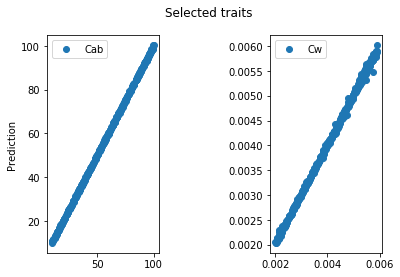

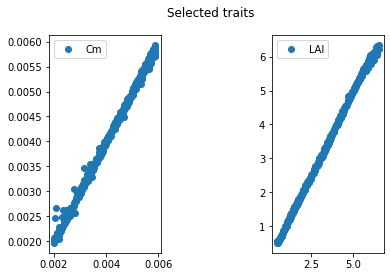

In [55]:


#plotting cab
fig, axs = plt.subplots(1,2)
fig.suptitle('Selected traits')
fig.subplots_adjust(wspace=1)

#plt.subplot(3,1,1)
axs[0].plot(pd_valid0500["cab"],test_pred[:,0],"o",label="Cab")
axs[0].legend(loc="upper left")
axs[0].set_ylabel("Prediction")

axs[1].plot(pd_valid0500["cw"],test_pred[:,1],"o",label="Cw")
axs[1].legend(loc="upper left")
#axs[1].set_ylabel("Prediction")

plt.show()

#plotting cab
fig, axs = plt.subplots(1,2)
fig.suptitle('Selected traits')
fig.subplots_adjust(wspace=1)


axs[0].plot(pd_valid0500["cm"],test_pred[:,2],"o",label="Cm")
axs[0].legend(loc="upper left")
#axs[0].set_ylabel("Prediction")

axs[1].plot(pd_valid0500["lai"],test_pred[:,3],"o",label="LAI")
axs[1].legend(loc="upper left")
#axs[3].set_ylabel("Prediction")